# Image Classification Model Deployment - CNN

**Raynold Panji Zulfiandi**

> Emotion Detection

> Dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

In [2]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.6.4


In [3]:
# cek penggunaan GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-10-10 08:07:29.453310: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 08:07:29.532233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 08:07:29.619263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 08:07:29.620023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Data Preparation

### Download Dataset (Google collbs)

In [6]:
!pip install -q kaggle
from google.colab import files 

# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raynoldpanji","key":"18f3f6dd72e3f4bcc0dbc0912582615b"}'}

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d ananthu017/emotion-detection-fer


 98% 64.0M/65.2M [00:03<00:00, 27.9MB/s]

100% 65.2M/65.2M [00:03<00:00, 22.2MB/s]


In [9]:
# !rm -rf datasets
!ls 

emotion-detection-fer.zip  kaggle.json	sample_data


In [10]:
!mkdir datasets
!unzip -q emotion-detection-fer.zip -d datasets
!ls datasets

test  train


### Download Datasets (kaggle notebook)

In [4]:
# !rm -rf datasets
!ls -al

total 16
drwxr-xr-x 3 root root 4096 Oct 10 08:07 .
drwxr-xr-x 5 root root 4096 Oct 10 08:07 ..
drwxr-xr-x 2 root root 4096 Oct 10 08:07 .virtual_documents
---------- 1 root root  263 Oct 10 08:07 __notebook_source__.ipynb


In [5]:
!mkdir ./datasets
!cp -r ../input/emotion-detection-fer/* ./datasets
!ls -al datasets

total 16
drwxr-xr-x 4 root root 4096 Oct 10 08:08 .
drwxr-xr-x 4 root root 4096 Oct 10 08:07 ..
drwxr-xr-x 9 root root 4096 Oct 10 08:08 test
drwxr-xr-x 9 root root 4096 Oct 10 08:11 train


In [6]:
!chmod 777 ./datasets/train
!chmod 777 ./datasets/test

!ls datasets/test

angry  disgusted  fearful  happy  neutral  sad	surprised


# Data Cleansing

In [7]:
import os

TRAINING_DIR = 'datasets/train/'
VALIDATION_DIR = 'datasets/test/'

os.listdir(TRAINING_DIR), os.listdir(VALIDATION_DIR)

(['angry', 'fearful', 'sad', 'happy', 'surprised', 'neutral', 'disgusted'],
 ['angry', 'fearful', 'sad', 'happy', 'surprised', 'neutral', 'disgusted'])

In [8]:
## cek jumlah dataset
def jum_data():
  train = []
  val = []
  lists = os.listdir(TRAINING_DIR)
  for cls in lists:
    train.append(len(os.listdir(os.path.join(TRAINING_DIR, cls))))
  for cls in lists:
    val.append(len(os.listdir(os.path.join(VALIDATION_DIR, cls))))
  return train, val, lists

def cek_data():
  chs = []
  train, val, lists = jum_data()
  
  msg="\n======================================"
  for i, cls in enumerate(lists):
    tot = train[i]+val[i]
    ch = round(tot*0.8)
    chs.append(ch-train[i])
    percen = ": "+str(80)+"% dari total ✓✓" if (ch==train[i]) else "-"
    msg=msg+f"\ntotal {cls}\t: {train[i]} ===> {ch} {percen}"
  msg=msg+"\ntotal : "+str(sum(train))
  
  msg=msg+"\n======================================"
  for i, cls in enumerate(lists):
    tot = train[i]+val[i]
    percen = ": "+str(20)+"% dari total ✓✓" if (round(tot*0.2)==val[i]) else "-"
    msg=msg+f"\ntotal {cls}\t: {val[i]} ===> {round(tot*0.2)} {percen}"
  msg=msg+"\ntotal : "+str(sum(val))

  msg=msg+"\n======================================"
  return msg, chs

print(cek_data()[0])
print(cek_data()[1])


total angry	: 3995 ===> 3962 -
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total sad	: 4830 ===> 4862 -
total happy	: 7215 ===> 7191 -
total surprised	: 3171 ===> 3202 -
total neutral	: 4965 ===> 4958 -
total disgusted	: 436 ===> 438 -
total : 28709
total angry	: 958 ===> 991 -
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total sad	: 1247 ===> 1215 -
total happy	: 1774 ===> 1798 -
total surprised	: 831 ===> 800 -
total neutral	: 1233 ===> 1240 -
total disgusted	: 111 ===> 109 -
total : 7178
[-33, 0, 32, -24, 31, -7, 2]


In [9]:
## hapus folder disgusted
import shutil
shutil.rmtree(os.path.join(TRAINING_DIR, 'disgusted') )
shutil.rmtree(os.path.join(VALIDATION_DIR, 'disgusted'))

os.listdir(TRAINING_DIR), os.listdir(VALIDATION_DIR)
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3995 ===> 3962 -
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total sad	: 4830 ===> 4862 -
total happy	: 7215 ===> 7191 -
total surprised	: 3171 ===> 3202 -
total neutral	: 4965 ===> 4958 -
total : 28273
total angry	: 958 ===> 991 -
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total sad	: 1247 ===> 1215 -
total happy	: 1774 ===> 1798 -
total surprised	: 831 ===> 800 -
total neutral	: 1233 ===> 1240 -
total : 7067
[-33, 0, 32, -24, 31, -7]


In [10]:
## pindahkan train test gambar agar sesuai kriteria 80/20

import random 

for i, dir in enumerate(jum_data()[2]):
  source = None
  dest = None

  if (cek_data()[1][i])<0:
    source = os.path.join(TRAINING_DIR, dir)
    dest = os.path.join(VALIDATION_DIR, dir)
  elif cek_data()[1][i]>0:
    source = os.path.join(VALIDATION_DIR, dir)
    dest = os.path.join(TRAINING_DIR, dir)
  
  if source==None:
    continue
  print("\n"+source+" ====> "+dest)
  files = os.listdir(source)

  for file_name in random.sample(files, abs(cek_data()[1][i])):
    shutil.move(os.path.join(source, file_name), os.path.join(dest, "mov_"+file_name))
    print(file_name+" moved")



datasets/train/angry ====> datasets/test/angry
im431.png moved
im3928.png moved
im3875.png moved
im1755.png moved
im3066.png moved
im3138.png moved
im1274.png moved
im2502.png moved
im2254.png moved
im3519.png moved
im342.png moved
im1435.png moved
im1385.png moved
im61.png moved
im1345.png moved
im3738.png moved
im2189.png moved
im560.png moved
im3366.png moved
im646.png moved
im2248.png moved
im3142.png moved
im2559.png moved
im99.png moved
im964.png moved
im2119.png moved
im819.png moved
im1730.png moved
im1921.png moved
im2888.png moved
im84.png moved
im847.png moved
im2100.png moved

datasets/test/sad ====> datasets/train/sad
im708.png moved
im370.png moved
im192.png moved
im486.png moved
im532.png moved
im1040.png moved
im883.png moved
im810.png moved
im162.png moved
im12.png moved
im780.png moved
im1157.png moved
im87.png moved
im933.png moved
im1114.png moved
im506.png moved
im381.png moved
im196.png moved
im1120.png moved
im101.png moved
im880.png moved
im922.png moved
im1167

In [11]:
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total sad	: 4862 ===> 4862 : 80% dari total ✓✓
total happy	: 7191 ===> 7191 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 4958 ===> 4958 : 80% dari total ✓✓
total : 28272
total angry	: 991 ===> 991 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total sad	: 1215 ===> 1215 : 20% dari total ✓✓
total happy	: 1798 ===> 1798 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 1240 ===> 1240 : 20% dari total ✓✓
total : 7068
[0, 0, 0, 0, 0, 0]


In [12]:
## Undersampling class happy

avg_undersampling = (sum(jum_data()[0]) / len(jum_data()[0])) / 7191  # persentase 0.6553

train_happy = 7191 - round(7191 * avg_undersampling)  # total train - 65,53% dari total train data: 4712
val_happy = 1798 - round(1798 * avg_undersampling)    # total val - 65,53% dari total val data: 1178

train_dir = os.path.join(TRAINING_DIR, 'happy')
val_dir = os.path.join(VALIDATION_DIR, 'happy')

for i, file_name in enumerate(random.sample(os.listdir(train_dir), train_happy)):
  os.remove(os.path.join(train_dir, file_name))
print(str(train_happy)+" files removed ")

for i, file_name in enumerate(random.sample(os.listdir(val_dir), val_happy)):
  os.remove(os.path.join(val_dir, file_name))
print(str(val_happy)+" files removed ")

2479 files removed 
620 files removed 


In [13]:
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total sad	: 4862 ===> 4862 : 80% dari total ✓✓
total happy	: 4712 ===> 4712 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 4958 ===> 4958 : 80% dari total ✓✓
total : 25793
total angry	: 991 ===> 991 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total sad	: 1215 ===> 1215 : 20% dari total ✓✓
total happy	: 1178 ===> 1178 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 1240 ===> 1240 : 20% dari total ✓✓
total : 6448
[0, 0, 0, 0, 0, 0]


In [14]:
## Undersampling class sad, happy, dan neutral
train_sampling = ((4958 + 4862 + 4712) // 3) - (3962 + 3202 + 4097) // 3  # rata2 data train yg besar - rata2 train yg kecil: 1091
val_sampling = ((1240 + 1215 + 1178) // 3) - (991 + 800 + 1024) // 3    # rata2 data val yg besar - rata2 val yg kecil: 273

# remove sebagian data pada data happy, neutral, dan sad
for u_dir in ['happy', 'neutral', 'sad']:
  train_dir = os.path.join(TRAINING_DIR, u_dir)
  val_dir = os.path.join(VALIDATION_DIR, u_dir)
  for i, file_name in enumerate(random.sample(os.listdir(train_dir), round(train_sampling))):
    os.remove(os.path.join(train_dir, file_name))
    continue
  print(f"{i+1} train {u_dir} files removed ")
  for i, file_name in enumerate(random.sample(os.listdir(val_dir), round(val_sampling))):
    os.remove(os.path.join(val_dir, file_name))
    continue
  print(f"{i+1} val {u_dir} files removed ")

1091 train happy files removed 
273 val happy files removed 
1091 train neutral files removed 
273 val neutral files removed 
1091 train sad files removed 
273 val sad files removed 


In [15]:
print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total sad	: 3771 ===> 3770 -
total happy	: 3621 ===> 3621 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 3867 ===> 3867 : 80% dari total ✓✓
total : 22520
total angry	: 991 ===> 991 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total sad	: 942 ===> 943 -
total happy	: 905 ===> 905 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 967 ===> 967 : 20% dari total ✓✓
total : 5629
[0, 0, -1, 0, 0, 0]


In [16]:
source = os.path.join(TRAINING_DIR, 'sad')
dest = os.path.join(VALIDATION_DIR, 'sad')
file = random.sample(os.listdir(source), 1)[0]

shutil.move(os.path.join(source, file), os.path.join(dest, "mov_"+file))
# print(os.path.join(source, file))

print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total fearful	: 4097 ===> 4097 : 80% dari total ✓✓
total sad	: 3770 ===> 3770 : 80% dari total ✓✓
total happy	: 3621 ===> 3621 : 80% dari total ✓✓
total surprised	: 3202 ===> 3202 : 80% dari total ✓✓
total neutral	: 3867 ===> 3867 : 80% dari total ✓✓
total : 22519
total angry	: 991 ===> 991 : 20% dari total ✓✓
total fearful	: 1024 ===> 1024 : 20% dari total ✓✓
total sad	: 943 ===> 943 : 20% dari total ✓✓
total happy	: 905 ===> 905 : 20% dari total ✓✓
total surprised	: 800 ===> 800 : 20% dari total ✓✓
total neutral	: 967 ===> 967 : 20% dari total ✓✓
total : 5630
[0, 0, 0, 0, 0, 0]


In [17]:
## backup datasets
!mkdir ./datasets/backup
!cp -r ./datasets/{train,test} ./datasets/backup
!ls -al ./datasets/backup

total 16
drwxr-xr-x 4 root root 4096 Oct 10 08:12 .
drwxr-xr-x 5 root root 4096 Oct 10 08:12 ..
drwxr-xr-x 8 root root 4096 Oct 10 08:12 test
drwxr-xr-x 8 root root 4096 Oct 10 08:12 train


In [18]:
## hapus class surprised dan fearful
shutil.rmtree(os.path.join(TRAINING_DIR, 'surprised') )
shutil.rmtree(os.path.join(VALIDATION_DIR, 'surprised'))

shutil.rmtree(os.path.join(TRAINING_DIR, 'neutral'))
shutil.rmtree(os.path.join(VALIDATION_DIR, 'neutral'))

shutil.rmtree(os.path.join(TRAINING_DIR, 'fearful'))
shutil.rmtree(os.path.join(VALIDATION_DIR, 'fearful'))

print(cek_data()[0])
print(cek_data()[1])


total angry	: 3962 ===> 3962 : 80% dari total ✓✓
total sad	: 3770 ===> 3770 : 80% dari total ✓✓
total happy	: 3621 ===> 3621 : 80% dari total ✓✓
total : 11353
total angry	: 991 ===> 991 : 20% dari total ✓✓
total sad	: 943 ===> 943 : 20% dari total ✓✓
total happy	: 905 ===> 905 : 20% dari total ✓✓
total : 2839
[0, 0, 0]


In [19]:
## Undersampling class angry
train_sampling = (sum(jum_data()[0]) / len(jum_data()[0]))*0.25
val_sampling = (sum(jum_data()[1]) / len(jum_data()[1]))*0.25

for u_dir in ['angry', 'sad', 'happy']:
  train_dir = os.path.join(TRAINING_DIR, u_dir)
  val_dir = os.path.join(VALIDATION_DIR, u_dir)
  for i, file_name in enumerate(random.sample(os.listdir(train_dir), round(train_sampling))):
    os.remove(os.path.join(train_dir, file_name))
    continue
  print(f"{round(train_sampling)} train {u_dir} files removed ")
  for i, file_name in enumerate(random.sample(os.listdir(val_dir), round(val_sampling))):
    os.remove(os.path.join(val_dir, file_name))
    continue
  print(f"{round(val_sampling)} val {u_dir} files removed ")

print(cek_data()[0])
print(cek_data()[1])

946 train angry files removed 
237 val angry files removed 
946 train sad files removed 
237 val sad files removed 
946 train happy files removed 
237 val happy files removed 

total angry	: 3016 ===> 3016 : 80% dari total ✓✓
total sad	: 2824 ===> 2824 : 80% dari total ✓✓
total happy	: 2675 ===> 2674 -
total : 8515
total angry	: 754 ===> 754 : 20% dari total ✓✓
total sad	: 706 ===> 706 : 20% dari total ✓✓
total happy	: 668 ===> 669 -
total : 2128
[0, 0, -1]


In [20]:
source = os.path.join(TRAINING_DIR, 'happy')
dest = os.path.join(VALIDATION_DIR, 'happy')
file = random.sample(os.listdir(source), 1)[0]

shutil.move(os.path.join(source, file), os.path.join(dest, "mov_"+file))
# print(os.path.join(source, file))


print(cek_data()[0])
print(cek_data()[1])


total angry	: 3016 ===> 3016 : 80% dari total ✓✓
total sad	: 2824 ===> 2824 : 80% dari total ✓✓
total happy	: 2674 ===> 2674 : 80% dari total ✓✓
total : 8514
total angry	: 754 ===> 754 : 20% dari total ✓✓
total sad	: 706 ===> 706 : 20% dari total ✓✓
total happy	: 669 ===> 669 : 20% dari total ✓✓
total : 2129
[0, 0, 0]


# Data Preprocessing

In [21]:
## Augmentasi data

from keras.preprocessing.image import ImageDataGenerator
training_datagen = ImageDataGenerator(
    rescale = 1./255.,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,  
)

img_size = 128
batch_size = 45

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR, 
    class_mode='categorical', 
    target_size=(img_size, img_size), 
    batch_size=batch_size,
#     color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(      
    VALIDATION_DIR,    
    class_mode='categorical',
    target_size=(img_size, img_size),
    batch_size=batch_size,
#     color_mode='grayscale'
)

Found 8514 images belonging to 3 classes.
Found 2129 images belonging to 3 classes.


In [22]:
train_generator.class_indices

{'angry': 0, 'happy': 1, 'sad': 2}

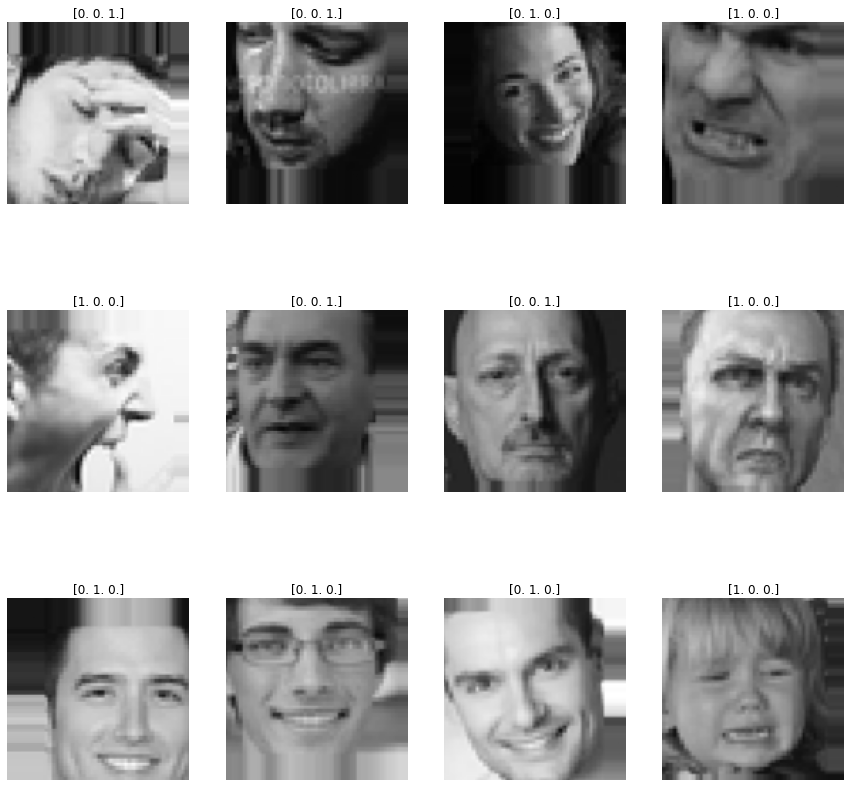

In [23]:
## Plot gambar

import numpy as np
import matplotlib.pylab as plt

plt.figure(figsize=[15,15])
for i in range(12):
    x, y = random.choice(train_generator)
    plt.subplot(3, 4, i+1)
    for im, lb in zip(x, y):
        plt.title(str(lb))
#         plt.imshow(im.reshape(img_size, img_size))
        plt.imshow(im)
        plt.axis('off')
plt.show()

# Training

In [38]:
# conv_base = tf.keras.applications.ResNet152V2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
conv_base = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')

conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_213 (Conv2D)             (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 63, 63, 32)   96          conv2d_213[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 63, 63, 32)   0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [49]:
## Frezze sebagian layer
# for layer in conv_base.layers[:-1]:
#   layer.trainable = False


## build architecture
num_cls = len(train_generator.class_indices)

model = tf.keras.models.Sequential([
  conv_base,

#   tf.keras.layers.Conv2D(512,(3,3), padding="same", activation="relu"),
  tf.keras.layers.Conv2D(512,(2,2), padding="same", activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.MaxPooling2D(2,2),
  
  tf.keras.layers.Flatten(),
  
#   tf.keras.layers.Dense(512, activation="relu", use_bias=True, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  tf.keras.layers.Dense(512, activation="relu", use_bias=True),
  tf.keras.layers.Dropout(0.5),
    
  tf.keras.layers.Dense(128, activation="relu", use_bias=True),
  tf.keras.layers.Dropout(0.5),

  # tf.keras.layers.Dense(128, activation="relu", use_bias=True),
  # tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Dense(num_cls, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
conv2d_418 (Conv2D)          (None, 2, 2, 512)         3146240   
_________________________________________________________________
dropout_18 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)              

In [50]:
## define callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = "val_accuracy",
  patience = 10,
  verbose = 0,
  mode = "auto",
  restore_best_weights=True
)

callbacks = [early_stopping]

In [51]:
## compile model
epochs = 100
lr = 0.01
decay_rate = lr / epochs
momentum=0.6

opt_adam = tf.optimizers.Adam(learning_rate=lr)
opt_rms = tf.optimizers.RMSprop(learning_rate=lr)
opt_sgd_par = tf.optimizers.SGD(learning_rate=lr, decay=decay_rate, momentum=momentum)
opt_sgd = tf.optimizers.SGD(learning_rate=lr)

model.compile(
  loss = 'categorical_crossentropy',
  optimizer = opt_sgd_par,
  metrics = ['accuracy']
)


## Train model

STEP_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = validation_generator.n // validation_generator.batch_size

with tf.device(device_name):
  history = model.fit(
      train_generator,
      steps_per_epoch = STEP_PER_EPOCH,
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = VALIDATION_STEPS,
      verbose = 1,
      callbacks = callbacks
  )

Epoch 1/100
189/189 [==============================] - 70s 282ms/step - loss: 0.2789 - accuracy: 0.8961 - val_loss: 0.6397 - val_accuracy: 0.7778
Epoch 2/100
189/189 [==============================] - 51s 267ms/step - loss: 0.1871 - accuracy: 0.9321 - val_loss: 0.8159 - val_accuracy: 0.7745
Epoch 3/100
189/189 [==============================] - 50s 264ms/step - loss: 0.1749 - accuracy: 0.9388 - val_loss: 0.8127 - val_accuracy: 0.7712
Epoch 4/100
189/189 [==============================] - 51s 267ms/step - loss: 0.1737 - accuracy: 0.9393 - val_loss: 0.8351 - val_accuracy: 0.7735
Epoch 5/100
189/189 [==============================] - 50s 265ms/step - loss: 0.1801 - accuracy: 0.9382 - val_loss: 0.6919 - val_accuracy: 0.7887
Epoch 6/100
189/189 [==============================] - 50s 265ms/step - loss: 0.1445 - accuracy: 0.9511 - val_loss: 0.7288 - val_accuracy: 0.7754
Epoch 7/100
189/189 [==============================] - 50s 266ms/step - loss: 0.1369 - accuracy: 0.9525 - val_loss: 0.7294 -

In [52]:
## model evaluate

loss, acc = model.evaluate(validation_generator)
print(f"valid accuracy: {acc} \nvalid loss: {loss}")

48/48 [==============================] - 4s 75ms/step - loss: 1.0377 - accuracy: 0.8079
valid accuracy: 0.8078910112380981 
valid loss: 1.0377315282821655


# Evaluation Model

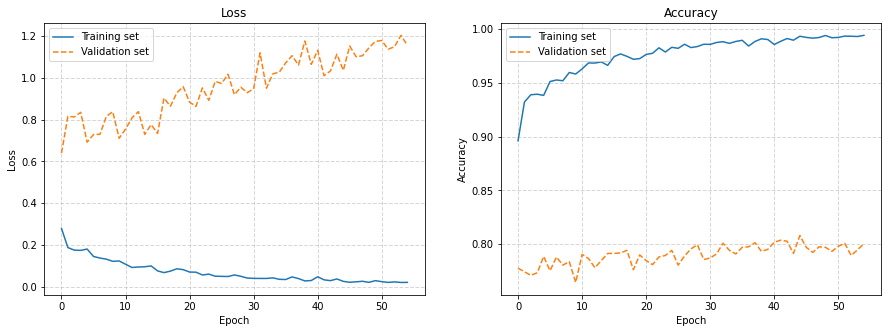

In [53]:
## Plot accuracy dan Loss

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

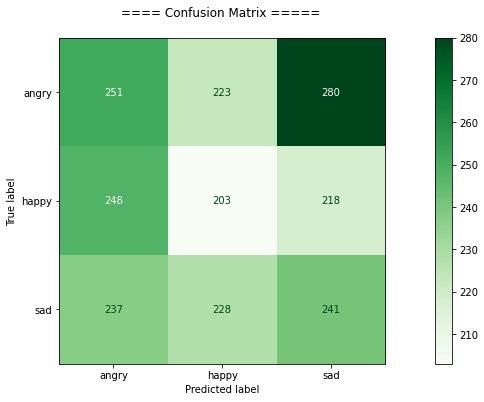


=============== Classification Report ================
              precision    recall  f1-score   support

       angry       0.34      0.33      0.34       754
       happy       0.31      0.30      0.31       669
         sad       0.33      0.34      0.33       706

    accuracy                           0.33      2129
   macro avg       0.33      0.33      0.33      2129
weighted avg       0.33      0.33      0.33      2129



In [54]:
## Plot Confusion Matrix dan Classification Report

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

labels_list = list(train_generator.class_indices.keys())


fig, ax = plt.subplots(figsize=(18, 6))
cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
disp.plot(cmap=plt.cm.Greens, ax=ax)
plt.title("==== Confusion Matrix ===== \n")
plt.show()


print("\n=============== Classification Report ================")
print(classification_report(validation_generator.classes, y_pred, target_names=labels_list))

# Deployment

In [55]:
## save model keras *.h5

if os.path.exists('model')==False:
  os.mkdir('model')

model.save_weights("model/model_weights.h5")
model.save("model/model.h5")

In [56]:
import warnings
warnings.filterwarnings('ignore')

## Convert Model keras ke tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

## save model *.tflite
with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-10-10 10:30:00.525456: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-10 10:31:14.191445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 10:31:14.191843: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-10-10 10:31:14.191996: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-10 10:31:14.192531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 10:31:14.192929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne